# Sex prediction

In [1]:
%load_ext autoreload
%autoreload 2

In [25]:

import sys

import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sn
import matplotlib.pyplot as plt
import numpy as np
import openpyxl
import umap

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import LabelBinarizer

sys.path.append('../src')
from utilities import baseline_accuracy
from utilities import dataplotmelt
from utilities import test_model
from utilities import nested_crossvalidation
from utilities import nested_ROC_plot
from utilities import montecarlo_crossvalidation
from utilities import gridsearch_bias
from utilities import model_optimization


In [3]:
colors = sn.color_palette("Set2") 

In [4]:
tsetse_data = pd.read_csv("../data/raw/TseTse_finaldataset.dat", sep='\t')

In [5]:
tsetse_data.rename(columns={"Cat1":"Plate", "Cat3":"Sex", "Cat4":"Age", "Cat5":"Tissue"}, inplace=True)
tsetse_data['Tissue'] = tsetse_data['Tissue'].str.replace("T", 'Thorax')
tsetse_data['Tissue'] = tsetse_data['Tissue'].str.replace("H", 'Head')
tsetse_data['Tissue'] = tsetse_data['Tissue'].str.replace("A", 'Abdomen')

In [6]:
tsetse_data_copy = tsetse_data.copy()

In [7]:
df_ic = pd.DataFrame(tsetse_data_copy.groupby(['Sex','Age','Tissue'])['ID'].count())
df_ic

ID
Sex Age Tissue                    
f   3d  Abdomen                 48
        Head                   133
        Thorax                 136
        ThoraxAbdomen20230206    1
    5w  Abdomen                 16
        Head                    92
        Thorax                  96
    7w  Abdomen                 38
        Head                   120
        Thorax                 122
m   5w  Head                    94
        Thorax                  93
    7w  Abdomen                 15
        Head                    93
        Thorax                  92

In [9]:
df_ic.to_excel("../results/tables/samples_summary.xlsx")

In [8]:
tsetse_data_sameages = tsetse_data[(tsetse_data["Age"]!= '3d')]
tsetse_data_sameages_copy = tsetse_data_sameages.copy()

In [9]:
dList=['Plate','Sex', 'Age', 'ID.1', 'Tissue','ID']
descriptorsDF_sameage = tsetse_data_sameages_copy[dList]
tsetse_data_sameages_copy.drop(dList, axis=1,inplace=True)

In [10]:
dList=['Plate','Sex', 'Age', 'ID.1', 'Tissue','ID']
descriptorsDF = tsetse_data[dList]
tsetse_data.drop(dList, axis=1,inplace=True)

wnLabels= tsetse_data.columns.values.tolist() #wavenumbers labels
waveNums = [int(x) for x in wnLabels] #wavenumbers numbers (for plotting)

## Clustering

In [39]:
tsetse_females = tsetse_data.loc[(descriptorsDF['Sex'] == 'f')]
tsetse_males = tsetse_data[(descriptorsDF['Sex'] == 'm')]

tsetse_head = tsetse_data_sameages_copy[(descriptorsDF_sameage['Tissue'] == 'Head')]
tsetse_thorax = tsetse_data_sameages_copy[(descriptorsDF_sameage['Tissue'] == 'Thorax')]
tsetse_abdomen = tsetse_data_sameages_copy[(descriptorsDF_sameage['Tissue'] == 'Abdomen')]

In [40]:
pca = PCA(n_components=5)
scaler_pca = StandardScaler()

X_scaled_head = scaler_pca.fit_transform(tsetse_head)
X_pca_head = pca.fit_transform(X_scaled_head)

X_scaled_thorax = scaler_pca.fit_transform(tsetse_thorax)
X_pca_thorax = pca.fit_transform(X_scaled_thorax)

In [41]:
# umap

reducer = umap.UMAP(n_neighbors = 30, transform_seed=123, min_dist=0.0)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(tsetse_head)
embedding_head = reducer.fit_transform(features_scaled)

# thorax
reducer = umap.UMAP(n_neighbors = 30, transform_seed=123, min_dist=0.0)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(tsetse_thorax)
embedding_thorax = reducer.fit_transform(features_scaled)


<Axes: >

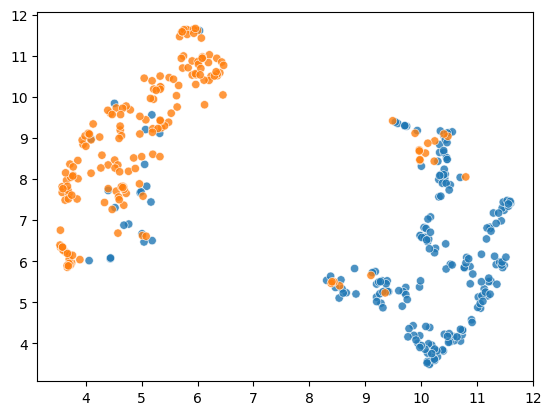

In [48]:
sn.scatterplot(x=embedding_head[:,0], y=embedding_head[:,1], hue=descriptorsDF_sameage[descriptorsDF_sameage['Tissue'] == 'Head']['Sex'], alpha=0.8, legend=False)

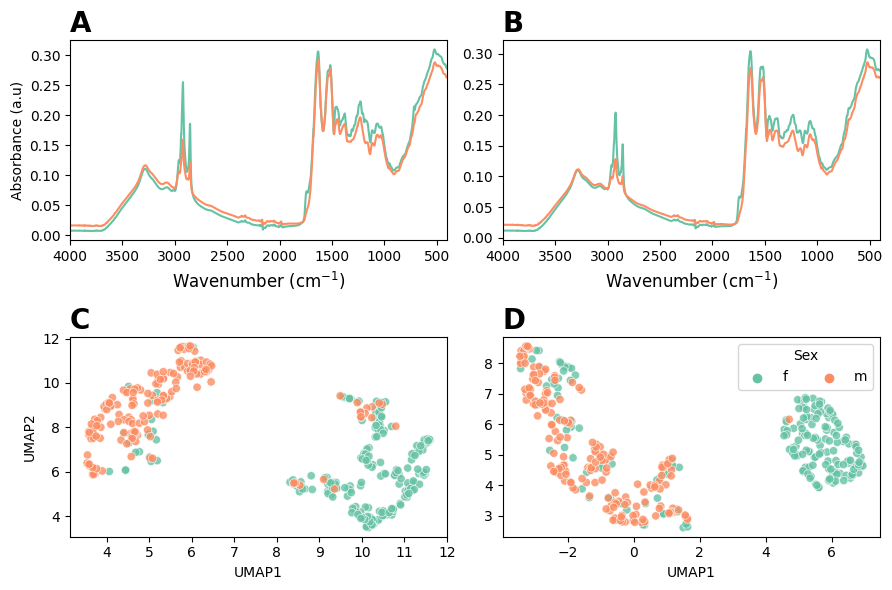

In [54]:
fig, ((ax2, ax3),(ax5, ax6)) = plt.subplots(2,2, figsize=(9,6))

sn.set_palette("Set2")
sn.scatterplot(x=embedding_head[:,0], y=embedding_head[:,1],ax=ax5, hue=descriptorsDF_sameage[descriptorsDF_sameage['Tissue'] == 'Head']['Sex'], alpha=0.8, legend=False)

sn.scatterplot(x=embedding_thorax[:,0], y=embedding_thorax[:,1],ax=ax6, hue=descriptorsDF_sameage[descriptorsDF_sameage['Tissue'] == 'Thorax']['Sex'], alpha=0.8)
ax6.legend(ncol=2, title='Sex')

y_labels = descriptorsDF_sameage[descriptorsDF_sameage['Tissue'] == 'Head']['Sex']

for i, c in zip(np.unique(y_labels), colors):
    sn.lineplot(x=waveNums, y=np.mean(tsetse_head[y_labels == i], axis=0), label=i, color=c,ax=ax2, legend=False)

ax2.set_xlim(4000,401)
ax2.set_xlabel("Wavenumber (cm$^{-1}$)",fontsize=12)
ax2.set_ylabel("Absorbance (a.u)")



y_labels = descriptorsDF_sameage[descriptorsDF_sameage['Tissue'] == 'Thorax']['Sex']
for i, c in zip(np.unique(y_labels), colors):
    sn.lineplot(x=waveNums, y=np.mean(tsetse_thorax[y_labels == i], axis=0), label=i, color=c,ax=ax3, legend=False)

ax3.set_xlim(4000,401)
ax3.set_xlabel("Wavenumber (cm$^{-1}$)",fontsize=12)

ax5.set_xlabel("UMAP1")
ax5.set_ylabel('UMAP2')
ax6.set_xlabel("UMAP1")



labeles = ["A", "B", "C", "D", "E", "F"]
axes = fig.get_axes()
for a, l in zip(axes, labeles):
    a.set_title(l, loc='left', fontsize=20, fontweight='bold')




plt.tight_layout()

plt.savefig("../results/plots/PCA_sex.png", dpi=900)

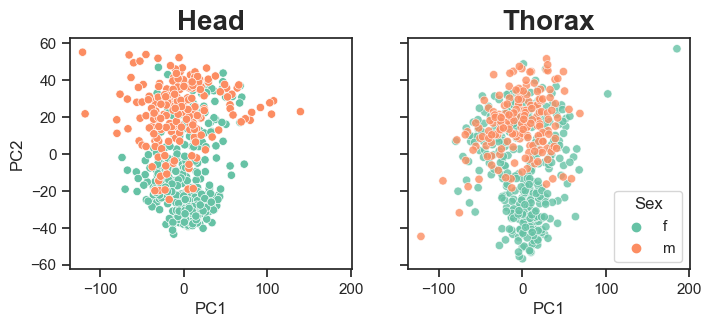

In [208]:
# PCA suplementary

fig, (ax,ax2) = plt.subplots(1,2, figsize=(8,3), sharey=True, sharex=True)
sn.scatterplot(x=X_pca_head[:,0], y=X_pca_head[:,1], hue=descriptorsDF[descriptorsDF['Tissue'] == 'Head']['Sex'], ax=ax, legend=False)

sn.scatterplot(x=X_pca_thorax[:,0], y=X_pca_thorax[:,1],ax=ax2, hue=descriptorsDF[descriptorsDF['Tissue'] == 'Thorax']['Sex'], alpha=0.8)

labeles = ["Head", "Thorax", "C", "D", "E", "F"]
axes = fig.get_axes()
for a, l in zip(axes, labeles):
    a.set_title(l, loc='center', fontsize=20, fontweight='bold')

ax.set_xlabel('PC1')
ax.set_ylabel("PC2")

ax2.set_xlabel('PC1')

plt.savefig("../results/plots/PCA_Suplementarysex.png", dpi=300)


## Sex prediction

In [11]:
tsetse_thorax = tsetse_data_copy.loc[descriptorsDF['Tissue'] == 'Thorax']
tsetse_head = tsetse_data_copy.loc[descriptorsDF['Tissue'] == 'Head']

In [12]:
tsetse_head.groupby("Sex")["ID"].count()

Sex
f    345
m    187
Name: ID, dtype: int64

In [13]:
X_thorax = tsetse_thorax.loc[:,"4000":"402"]
y_thorax = tsetse_thorax.loc[:,"Sex"]

X_head = tsetse_head.loc[:,"4000":"402"]
y_head = tsetse_head.loc[:,"Sex"]

In [14]:
thorax_labels = descriptorsDF_sameage[descriptorsDF_sameage['Tissue'] == 'Thorax']

thorax_labels_age = thorax_labels['Age']
thorax_labels_age

274     5w
276     5w
278     5w
280     5w
282     5w
        ..
1180    5w
1182    5w
1184    5w
1186    5w
1188    5w
Name: Age, Length: 403, dtype: object

In [15]:
tsetse_data_head = tsetse_data_sameages[tsetse_data_sameages["Tissue"] == 'Head']

tsetse_data_head_copy = tsetse_data_head.copy()

In [16]:
y_labels = descriptorsDF_sameage[descriptorsDF_sameage['Tissue'] == 'Thorax']['Sex']



In [17]:
y_labels.value_counts()

Sex
f    218
m    185
Name: count, dtype: int64

## Bias test

In [19]:
X_thorax_part1 = X_thorax_sameage.loc[:,"4000":"402"]
X_thorax_part2 = X_thorax_sameage.loc[:,"1800":"600"]
X_thorax_part3 = X_thorax_sameage.loc[:,"3500":"2750"]
X_thorax_part4 = X_thorax_sameage.loc[:,"2750":"1800"]

X_thorax_desbiased = pd.concat([X_thorax_part3,X_thorax_part2],axis=1)

#y_thorax_sameage

In [23]:
# thorax
bias_test_part1 = gridsearch_bias(X_thorax_part1,y_labels)
bias_test_part2 = gridsearch_bias(X_thorax_part2,y_labels)
bias_test_part3 = gridsearch_bias(X_thorax_part3,y_labels)
bias_test_part4 = gridsearch_bias(X_thorax_part4,y_labels)
bias_test_part5 = gridsearch_bias(X_thorax_desbiased,y_labels)

In [24]:
result = pd.concat([bias_test_part1, bias_test_part2['mean_test_score'],bias_test_part3['mean_test_score'],bias_test_part4['mean_test_score'],bias_test_part5['mean_test_score']], axis=1)
result

result.to_excel("../results/tables/results_thorax_biased_sex_pred.xlsx")

In [37]:
X_head_part1 = tsetse_data_head.loc[:,"4000":"402"]
X_head_part2 = tsetse_data_head.loc[:,"1800":"600"]
X_head_part3 = tsetse_data_head.loc[:,"3500":"2750"]
X_head_part4 = tsetse_data_head.loc[:,"2750":"1800"]

X_head_desbiased = pd.concat([X_head_part3,X_head_part2],axis=1)

y_head_sameage = tsetse_data_head.loc[:,'Age']

In [39]:
bias_test_head_part1 = gridsearch_bias(X_head_part1, y_head_sameage)
bias_test_head_part2 = gridsearch_bias(X_head_part2, y_head_sameage)
bias_test_head_part3 = gridsearch_bias(X_head_part3, y_head_sameage)
bias_test_head_part4 = gridsearch_bias(X_head_part4, y_head_sameage)
bias_test_head_part5 = gridsearch_bias(X_head_desbiased, y_head_sameage)

In [40]:
result = pd.concat([bias_test_head_part1, 
    bias_test_head_part2['mean_test_score'],
    bias_test_head_part3['mean_test_score'],
    bias_test_head_part4['mean_test_score'],
    bias_test_head_part5['mean_test_score']], axis=1)

result.to_excel("../results/tables/results_biased_head_sex_pred.xlsx")

In [45]:
# permutation test

from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import permutation_test_score

clf = SVC(kernel="linear", random_state=7)
cv = StratifiedKFold(2, shuffle=True, random_state=0)

score_iris, perm_scores_iris, pvalue_iris = permutation_test_score(
    clf, X_thorax_sameage, thorax_labels_age, scoring="accuracy", cv=cv, n_permutations=1000)





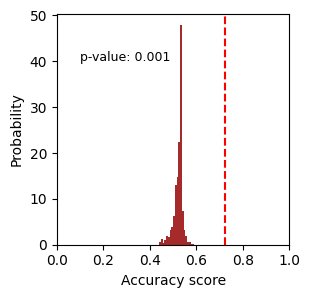

In [49]:
fig, ax = plt.subplots(figsize=(3,3))
ax.hist(perm_scores_iris, bins=20, density=True, color='brown')
ax.axvline(score_iris, ls="--", color="r")
score_label = f"p-value: {pvalue_iris:.3f}"
ax.text(0.1, 40, score_label, fontsize=9)
ax.set_xlabel("Accuracy score")
ax.set_ylabel("Probability")
ax.set_xlim(0,1)

plt.savefig("../results/plots/permutationtest_sex.png", dpi=300, bbox_inches='tight')


In [81]:
X_thorax.to_csv("../data/processed/X_thorax.csv", index=False)
y_thorax.to_csv("../data/processed/y_thorax_sex.csv", index=False)

# Sex predictioin

In [18]:
X_th_train, X_th_test, y_th_train, y_th_test = train_test_split(X_thorax, y_thorax, test_size=0.2, shuffle=True, random_state=123)

X_hd_train, X_hd_test, y_hd_train, y_hd_test = train_test_split(X_head, y_head, test_size=0.2, shuffle=True, random_state=123)

In [19]:
print(X_hd_train.shape)
print(X_hd_test.shape)

print(X_th_train.shape)
print(X_th_test.shape)

(425, 1800)
(107, 1800)
(431, 1800)
(108, 1800)


In [20]:
shape_data = {"train_head": X_hd_train.shape,
              "train_thorax": X_th_train.shape,
              "test_head": X_hd_test.shape,
              "tsetse_thorax":X_th_test.shape}

In [21]:
shape_data_df = pd.DataFrame(shape_data,index=['samples','features'])

shape_data_df

,train_head,train_thorax,test_head,tsetse_thorax
samples,425,431,107,108
features,1800,1800,1800,1800


In [27]:
shape_data_df.to_excel("../results/tables/train_test_shape_sex.xlsx")

In [22]:
thorax_acc_baseline = baseline_accuracy(X_th_train, y_th_train)
head_acc_baseline = baseline_accuracy(X_hd_train,y_hd_train)

Fitting 10 folds for each of 4 candidates, totalling 40 fits
Fitting 10 folds for each of 4 candidates, totalling 40 fits


In [23]:
data_plot_thorax = dataplotmelt(thorax_acc_baseline)
data_plot_head = dataplotmelt(head_acc_baseline)

In [65]:
output = data_plot_head.groupby(['param_clf'], as_index=False).agg({'value':['mean','std']})
print(output)

  param_clf     value          
                 mean       std
0      CART  0.788235  0.045055
1        LR  0.947059  0.020935
2        RF  0.869412  0.030603
3       SVC  0.882353  0.014673


In [66]:
output = data_plot_thorax.groupby(['param_clf'], as_index=False).agg({'value':['mean','std']})
print(output)

  param_clf     value          
                 mean       std
0      CART  0.805747  0.044829
1        LR  0.925287  0.031711
2        RF  0.836782  0.037068
3       SVC  0.864368  0.026984


In [26]:
# model optimization

# Head
best_model_head = model_optimization(X_hd_train,y_hd_train)
# thorax
best_mdoel_thorax = model_optimization(X_th_train, y_th_train)

Best model parameters{'model__C': 10, 'model__penalty': 'l2', 'model__solver': 'newton-cg'}
Best model parameters{'model__C': 100, 'model__penalty': 'l2', 'model__solver': 'liblinear'}


In [27]:
# test head

y_head_pred, y_head_prob, pipe_head = test_model(X_hd_train, X_hd_test, y_hd_train, best_model_head)
y_thorax_pred, y_thorax_prob, pipe_thorax = test_model(X_th_train, X_th_test, y_th_train, best_mdoel_thorax)

In [28]:
accuracy_head = accuracy_score(y_hd_test, y_head_pred)
accuracy_thorax = accuracy_score(y_th_test, y_thorax_pred)
print(f"Accuracy on test set: {accuracy_head}")
print(f"Accuracy on test set: {accuracy_thorax}")

Accuracy on test set: 0.9719626168224299
Accuracy on test set: 0.9259259259259259


In [29]:
report_head = classification_report(y_hd_test, y_head_pred, output_dict=True)
report_head = pd.DataFrame(report_head).transpose()
report_head

,precision,recall,f1-score,support
f,0.962025,1.000000,0.980645,76.000000
m,1.000000,0.903226,0.949153,31.000000
accuracy,0.971963,0.971963,0.971963,0.971963
macro avg,0.981013,0.951613,0.964899,107.000000
weighted avg,0.973027,0.971963,0.971521,107.000000


In [51]:
report_head.to_excel("../results/tables/accuracy_sex_head.xlsx")

In [30]:
report_thorax = classification_report(y_th_test, y_thorax_pred, output_dict=True)
report_thorax = pd.DataFrame(report_thorax).transpose()
report_thorax

,precision,recall,f1-score,support
f,0.957746,0.931507,0.944444,73.000000
m,0.864865,0.914286,0.888889,35.000000
accuracy,0.925926,0.925926,0.925926,0.925926
macro avg,0.911306,0.922896,0.916667,108.000000
weighted avg,0.927646,0.925926,0.926440,108.000000


In [52]:
report_thorax.to_excel("../results/tables/accuracy_sex_thorax.xlsx")

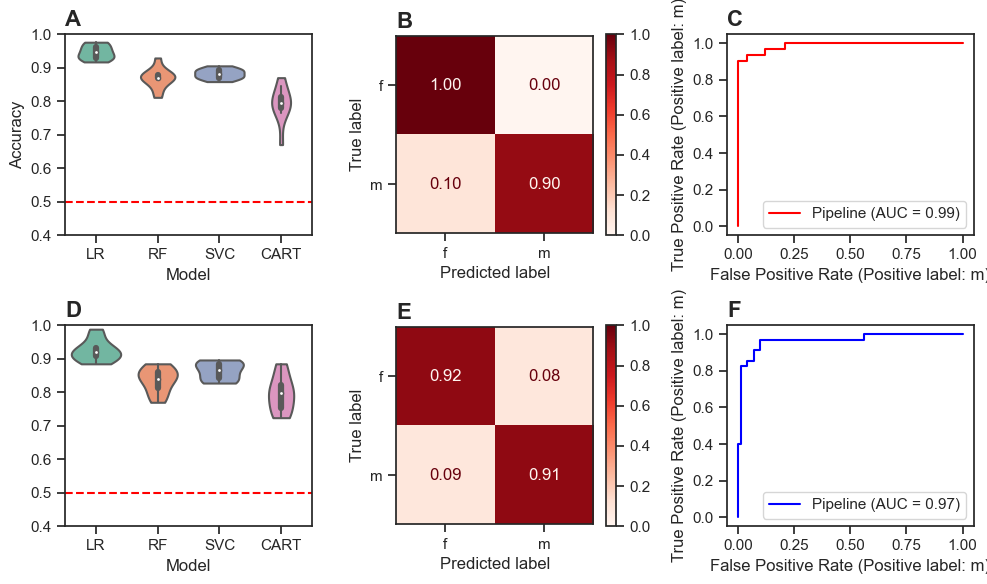

In [209]:
fig, ((ax,ax2, ax5),(ax3,ax4, ax6)) = plt.subplots(2,3,figsize=(10,6))
sn.violinplot(data=data_plot_head, x='param_clf',y='value',ax=ax, cut=0)
sn.violinplot(data=data_plot_thorax, x='param_clf', y='value', cut=0,ax=ax3)
ax.set_xlabel("Model")
ax.set_ylabel('Accuracy')
ax.set_ylim(0.4,1)
ax3.set_ylim(0.4,1)
ax.axhline(0.5, color='r',ls="--")
ax3.axhline(0.5, color='r',ls="--")
ax3.set_ylabel('')
ax3.set_xlabel("Model")


disp = ConfusionMatrixDisplay.from_predictions(y_hd_test,y_head_pred,display_labels=pipe_head.classes_, normalize='true', values_format='.2f', cmap=plt.cm.Reds, ax=ax2, im_kw={'vmin':0, 'vmax':1})


disp = ConfusionMatrixDisplay.from_predictions(y_th_test,y_thorax_pred,display_labels=pipe_thorax.classes_, normalize='true', values_format='.2f', cmap=plt.cm.Reds, ax=ax4, im_kw={'vmin':0, 'vmax':1})


RocCurveDisplay.from_estimator(pipe_head, X=X_hd_test, y=y_hd_test, ax=ax5, color='r')

RocCurveDisplay.from_estimator(pipe_thorax, X=X_th_test, y=y_th_test, ax=ax6, color='b')

sizeletters = 16
ax.set_title("A", loc='left', weight='bold',size=sizeletters)
ax2.set_title("B", loc='left', weight='bold', size=sizeletters)
ax3.set_title("D", loc='left', weight='bold', size=sizeletters)
ax4.set_title("E", loc='left', weight='bold', size=sizeletters)
ax5.set_title("C", loc='left', weight='bold', size=sizeletters)
ax6.set_title("F", loc='left', weight='bold', size=sizeletters)

plt.tight_layout()

plt.savefig("../results/plots/sex_prediction.png", dpi=300)


<Axes: >

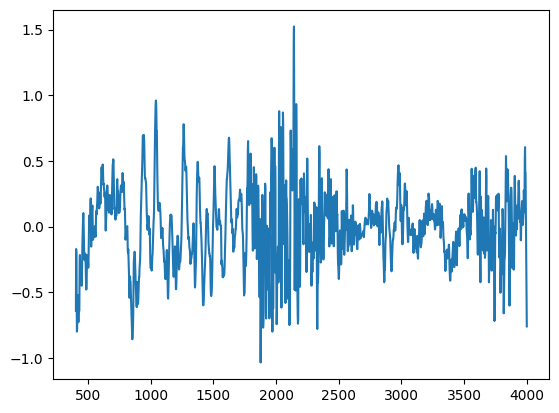

In [31]:
# coefficients

sn.lineplot(x=waveNums, y=best_model_head['model'].coef_[0])

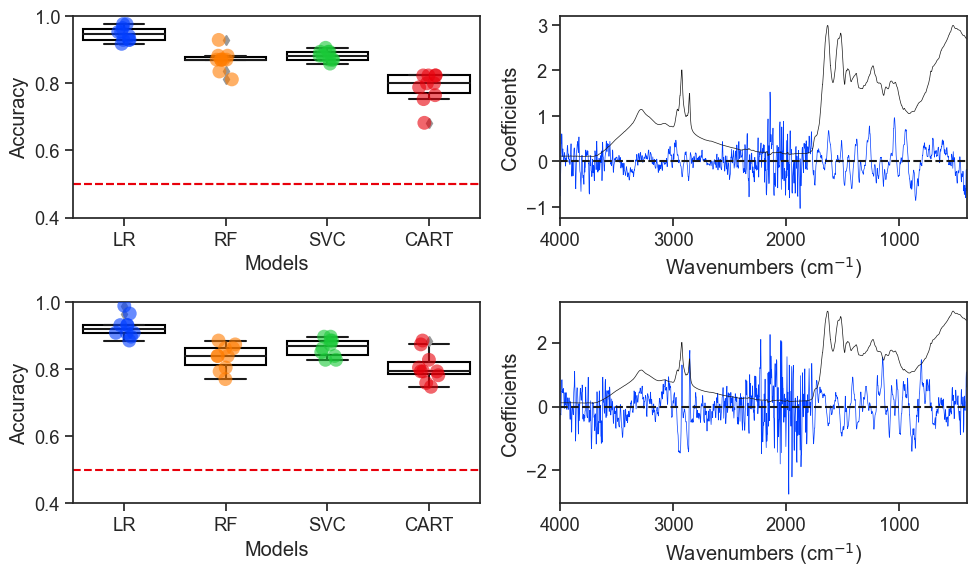

In [59]:
# final plot

sn.set(font_scale=1.2)
sn.set_style("ticks")
sn.set_palette('bright', color_codes=True)

fig, ((ax, ax2),(ax3, ax4)) = plt.subplots(2, 2, figsize=(10,6), tight_layout=True)

sn.boxplot(data=data_plot_head, x='param_clf',y='value',ax=ax, color='white')
sn.stripplot(data=data_plot_head, x='param_clf',y='value',ax=ax,size=10, hue='param_clf', alpha=0.6, legend=False)
plt.setp(ax.lines, color='k')

for l, box in enumerate(ax.patches):
    box.set_edgecolor('black')

ax.axhline(0.5, color='r', ls='--')
ax.set_ylim(0.4,1)


sn.boxplot(data=data_plot_thorax, x='param_clf', y='value',ax=ax3, color="white")
sn.stripplot(data=data_plot_thorax, x='param_clf',y='value',ax=ax3,size=10, hue='param_clf', alpha=0.6, legend=False)
plt.setp(ax3.lines, color='k')
for l, box in enumerate(ax3.patches):
    box.set_edgecolor('black')







sn.lineplot(x=waveNums, y=best_model_head['model'].coef_[0], ax=ax2, linewidth=0.5)
sn.lineplot(x=waveNums, y=best_mdoel_thorax['model'].coef_[0], ax=ax4, linewidth=0.5)


plots1 = [ax2,ax4]

for i in plots1:
    i.axhline(0, color='k', ls='--')
    sn.lineplot(x=waveNums, y=np.mean(X_hd_train, axis=0)*10, linewidth=0.5, color='k', ax=i)
    i.set_xlim(4000, 400)
    i.set_ylabel("Coefficients")
    i.set_xlabel("Wavenumbers (cm$^{-1}$)")


plots2 = [ax,ax3]
for i in plots2:
    i.axhline(0.5, color='r', ls='--')
    i.set_ylim(0.4,1)
    i.set_xlabel("Models")
    i.set_ylabel("Accuracy")


plt.savefig("../results/plots/sex_predicton_final.png", dpi=900, bbox_inches='tight')

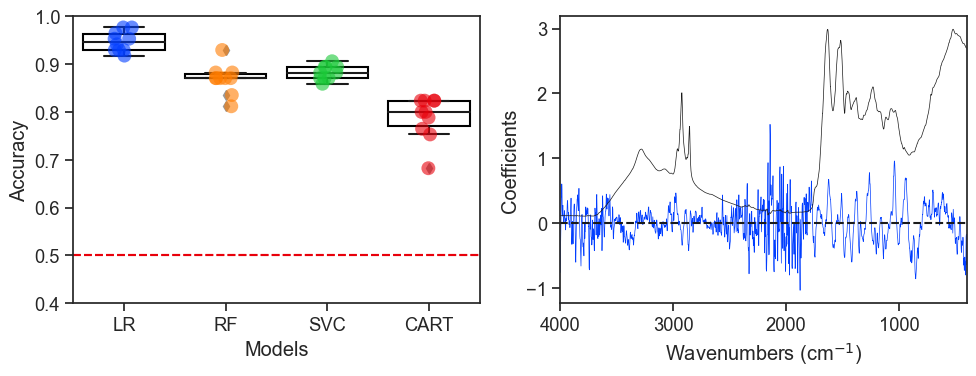

In [62]:
# final plot

sn.set(font_scale=1.2)
sn.set_style("ticks")
sn.set_palette('bright', color_codes=True)

fig, (ax, ax2) = plt.subplots(1, 2, figsize=(10,4), tight_layout=True)

sn.boxplot(data=data_plot_head, x='param_clf',y='value',ax=ax, color='white')
sn.stripplot(data=data_plot_head, x='param_clf',y='value',ax=ax,size=10, hue='param_clf', alpha=0.6, legend=False)
plt.setp(ax.lines, color='k')

for l, box in enumerate(ax.patches):
    box.set_edgecolor('black')

ax.axhline(0.5, color='r', ls='--')
ax.set_ylim(0.4,1)



sn.lineplot(x=waveNums, y=best_model_head['model'].coef_[0], ax=ax2, linewidth=0.5)


plots1 = [ax2,ax4]

for i in plots1:
    i.axhline(0, color='k', ls='--')
    sn.lineplot(x=waveNums, y=np.mean(X_hd_train, axis=0)*10, linewidth=0.5, color='k', ax=i)
    i.set_xlim(4000, 400)
    i.set_ylabel("Coefficients")
    i.set_xlabel("Wavenumbers (cm$^{-1}$)")


plots2 = [ax,ax3]
for i in plots2:
    i.axhline(0.5, color='r', ls='--')
    i.set_ylim(0.4,1)
    i.set_xlabel("Models")
    i.set_ylabel("Accuracy")


plt.savefig("../results/plots/sex_predicton_final_v2.pdf", dpi=900, bbox_inches='tight')

## Nested cross validation

In [82]:
X_thorax_nested = pd.read_csv("../data/processed/X_thorax.csv")
y_thorax_nested = pd.read_csv("../data/processed/y_thorax_sex.csv")

In [102]:
lb = LabelBinarizer()
y_thorax_encoded = lb.fit_transform(y_thorax)

In [133]:
cm_nested_th, y_pred_nested_th, y_test_nested_th, nested_accuracy =  nested_crossvalidation(X_thorax, y_thorax_encoded.ravel())

Acc=0.981, auc-roc=0.980, cfg={'model__C': 100, 'model__solver': 'liblinear'}
Acc=1.000, auc-roc=0.978, cfg={'model__C': 100, 'model__solver': 'newton-cg'}
Acc=0.944, auc-roc=0.983, cfg={'model__C': 100, 'model__solver': 'liblinear'}
Acc=0.963, auc-roc=0.977, cfg={'model__C': 100, 'model__solver': 'liblinear'}
Acc=0.963, auc-roc=0.985, cfg={'model__C': 100, 'model__solver': 'liblinear'}
Acc=0.981, auc-roc=0.981, cfg={'model__C': 100, 'model__solver': 'newton-cg'}
Acc=1.000, auc-roc=0.981, cfg={'model__C': 100, 'model__solver': 'liblinear'}
Acc=0.944, auc-roc=0.975, cfg={'model__C': 10, 'model__solver': 'newton-cg'}
Acc=0.907, auc-roc=0.984, cfg={'model__C': 100, 'model__solver': 'newton-cg'}
Acc=0.887, auc-roc=0.988, cfg={'model__C': 100, 'model__solver': 'liblinear'}
Mean accuracy: 0.96 (0.04)


In [107]:
lb = LabelBinarizer()
y_head_encoded = lb.fit_transform(y_head)

In [137]:
cm_nested_head, y_pred_nested_head, y_test_nested_head, accuracy_nested_head =  nested_crossvalidation(X_head, y_head_encoded.ravel())

Acc=0.944, auc-roc=0.988, cfg={'model__C': 100, 'model__solver': 'newton-cg'}
Acc=0.907, auc-roc=0.993, cfg={'model__C': 100, 'model__solver': 'lbfgs'}
Acc=0.981, auc-roc=0.990, cfg={'model__C': 100, 'model__solver': 'liblinear'}
Acc=0.962, auc-roc=0.990, cfg={'model__C': 100, 'model__solver': 'newton-cg'}
Acc=0.962, auc-roc=0.991, cfg={'model__C': 10, 'model__solver': 'liblinear'}
Acc=0.962, auc-roc=0.990, cfg={'model__C': 100, 'model__solver': 'liblinear'}
Acc=0.981, auc-roc=0.989, cfg={'model__C': 100, 'model__solver': 'liblinear'}
Acc=0.962, auc-roc=0.990, cfg={'model__C': 100, 'model__solver': 'liblinear'}
Acc=0.962, auc-roc=0.994, cfg={'model__C': 100, 'model__solver': 'newton-cg'}
Acc=0.981, auc-roc=0.989, cfg={'model__C': 100, 'model__solver': 'newton-cg'}
Mean accuracy: 0.96 (0.02)


In [151]:
accuracies_nested = pd.DataFrame({'head':accuracy_nested_head, 'thorax': nested_accuracy})

In [153]:
accuracies_nested_melt = pd.melt(accuracies_nested)
accuracies_nested_melt

,variable,value
0,head,0.944444
1,head,0.907407
2,head,0.981132
3,head,0.962264
4,head,0.962264
5,head,0.962264
6,head,0.981132
7,head,0.962264
8,head,0.962264
9,head,0.981132


Mean AUC = 0.987 (0.009)
Mean AUC = 0.981 (0.017)


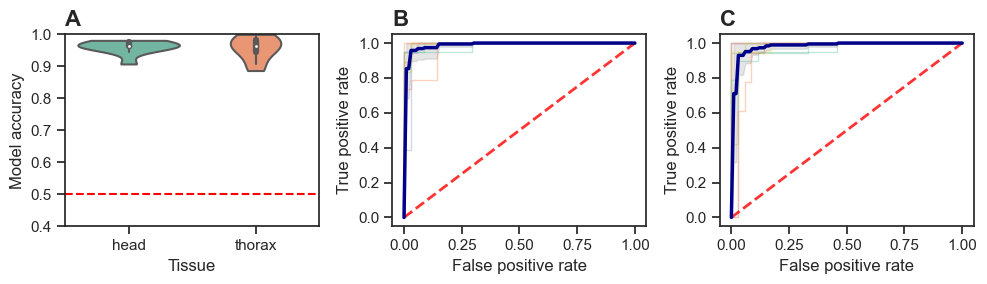

In [175]:
sn.set_context('notebook',font_scale=1)

fig, (ax, ax2, ax3) = plt.subplots(1,3, figsize=(10,3))
sn.violinplot(accuracies_nested_melt, x='variable', y='value', ax=ax, cut=0)
ax.set_xlabel("Tissue")
ax.set_ylabel("Model accuracy")
ax.set_ylim(0.4,1)
ax.axhline(0.5, color='r', ls='--')

nested_ROC_plot(y_test_nested_head, y_pred_nested_head, ax=ax2)
nested_ROC_plot(y_test_nested_th, y_pred_nested_th, ax=ax3)

ax.set_title("A", loc='left', weight='bold',size=sizeletters)
ax2.set_title("B", loc='left', weight='bold',size=sizeletters)
ax3.set_title("C", loc='left', weight='bold',size=sizeletters)

plt.tight_layout()

plt.savefig("../results/plots/BOX_ROC_nested_sex.png",dpi=900)

## monte carlo cross validation


In [52]:
# monte carlo cross validation

accuracy_head_mc, sensitivity_head_mc, specificity_head_mc = montecarlo_crossvalidation(X_head, y_head)


Model perfomance using monte carlo cross-validation
Mean accuracy = 0.96 ± 0.02
Sensitivity = 0.93 ± 0.05
Specificity = 0.97 ± 0.02


In [53]:
accuracy_thorax_mc, sensitivity_thorax_mc, specificity_thorax_mc = montecarlo_crossvalidation(X_thorax, y_thorax)

Model perfomance using monte carlo cross-validation
Mean accuracy = 0.95 ± 0.02
Sensitivity = 0.94 ± 0.04
Specificity = 0.95 ± 0.02


In [54]:
monte_carlo = pd.DataFrame({"Accuracy": [np.mean(accuracy_head_mc),
                                         np.mean(accuracy_thorax_mc)], 
                            "std":[np.std(accuracy_head_mc),
                                   np.std(accuracy_thorax_mc)], 
                            "Sensitivity":[np.mean(sensitivity_head_mc),
                                           np.mean(sensitivity_thorax_mc)],
                            "std_s": [np.std(sensitivity_head_mc),
                                           np.std(sensitivity_thorax_mc)],
                            "Specificity": [np.mean(specificity_head_mc),
                                          np.mean(specificity_thorax_mc)],
                            "std_sp": [np.std(specificity_head_mc),
                                          np.std(specificity_thorax_mc)]}, index=['head','thorax'])

In [55]:
monte_carlo.to_excel("../results/tables/sex_prediction_mc.xlsx")